<a href="https://colab.research.google.com/github/100emoji/Landscape-Generation-and-Classification/blob/main/LandscapeGenerationClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Google Drive Mount

In [ ]:
%pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function, division
import numpy as np
import time
import matplotlib.pyplot as plt
import time
import copy
import seaborn as sns
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data
import torch.backends.cudnn as cudnn
from torchvision import transforms
from torch.optim import lr_scheduler
from torchinfo import summary

# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

cudnn.benchmark = True
plt.ion()   # interactive mode

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-dc86b91d-bcea-4783-7cfd-99adbf35ce4d)


# Data Processing

## Data Transforms and Split

In [ ]:
main = '/content/gdrive/MyDrive/landscape-generation-and-classification'

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop((125, 125)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomResizedCrop(size=150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 70-15-15 split
dataset = torchvision.datasets.ImageFolder(main + '/project_dataset', transform=transform)

train_size = int(0.7 * len(dataset))
test_size = int(0.15 * len(dataset)) + 1
val_size = int(0.15 * len(dataset))

print(len(dataset))
print(train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])


29034
20323 4355 4356


## Weighted Oversampling using Image Augmentation

In [ ]:
# With Augmentation
transform_train_subset = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop((125, 125)),
    transforms.RandomRotation(degrees=45),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.05),
    transforms.RandomResizedCrop(size=150, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# calculate the number of examples to sample from each class
class_indices = np.array([1831, 1701, 3614, 3732, 3780, 3664, 2001])
max_class_size = 3780
class_weights = [(3780 / class_indices[c]) for c in range(7)]
num_samples = [int(class_weights[c] * class_indices[c]) for c in range(7)]

#for easier access simply copy paste the weights from sample_weights.txt as this loop will take a while to run
sample_weights = np.zeros(len(train_dataset))
sample_weights = [class_weights[label] for _, label in train_dataset]
for idx, (tensor, label) in enumerate(train_dataset):
    class_weight = class_weights[label]
    sample_weights[idx] = class_weight

# create a WeightedRandomSampler to oversample the training set
sampler = data.WeightedRandomSampler(weights=sample_weights, num_samples=sum(num_samples), replacement=True)

# create new training set with oversampled examples
oversampled_train_dataset = data.Subset(train_dataset, indices=list(sampler))

# Sampling the subset
oversampled_train_dataset.transform = transform_train_subset

print(len(oversampled_train_dataset), len(train_dataset))

[2.0644456581103223, 2.2222222222222223, 1.0459324847814055, 1.0128617363344052, 1.0, 1.0316593886462881, 1.8890554722638682]
[3780, 3780, 3779, 3780, 3780, 3779, 3780]
26458 20323


# Baseline CNN

In [ ]:
class CNNbaseline(nn.Module):
  def __init__(self, name = "CNN"):
    super(CNNbaseline, self).__init__()
    self.name = name
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.fc1 = nn.Linear(64 * 37 * 37, 128)
    self.fc2 = nn.Linear(128, 7)

  def forward(self, img):
    x = self.pool(F.relu(self.conv1(img)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 37 * 37)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

model = CNNbaseline()
summary(model=model, 
        input_size=(64, 3, 150, 150), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNNbaseline (CNNbaseline)                [64, 3, 150, 150]    [64, 7]              --                   True
├─Conv2d (conv1)                         [64, 3, 150, 150]    [64, 32, 150, 150]   896                  True
├─MaxPool2d (pool)                       [64, 32, 150, 150]   [64, 32, 75, 75]     --                   --
├─Conv2d (conv2)                         [64, 32, 75, 75]     [64, 64, 75, 75]     18,496               True
├─MaxPool2d (pool)                       [64, 64, 75, 75]     [64, 64, 37, 37]     --                   --
├─Linear (fc1)                           [64, 87616]          [64, 128]            11,214,976           True
├─Linear (fc2)                           [64, 128]            [64, 7]              903                  True
Total params: 11,235,271
Trainable params: 11,235,271
Non-trainable params: 0
Total mult-adds (G): 8.67
Input size (MB): 17.28


## Training Helper Functions

### Get Model Path

In [ ]:
def get_model_path(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

### Get accuracy

In [ ]:
def get_accuracy(model, data_loader):
  data = data_loader
  use_cuda = True
  correct = 0
  total = 0
  for imgs, labels in data:
    
    #############################################
    #To Enable GPU Usage
    if use_cuda and torch.cuda.is_available():
      imgs = imgs.cuda()
      labels = labels.cuda()
    #############################################

    torch.unsqueeze(labels, 1)   
    output = model(imgs)
    
    #select index with maximum prediction score
    pred = output.max(1, keepdim=True)[1]
    correct += pred.eq(labels.view_as(pred)).sum().item()
    total += imgs.shape[0]
    
  return correct / total

### Train Loop for CNN

In [ ]:
def trainCNN(model, train_dataset, val_dataset, batch_size=32, learn_rate = 0.01, num_epochs=1):
  
  train_loader = torch.utils.data.DataLoader(oversampled_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
  criterion = nn.CrossEntropyLoss()

  #optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)
  optimizer = optim.Adam(model.parameters(), lr=learn_rate)

  iters, losses, train_acc, val_acc = [], [], [], []

  use_cuda = True
  # training
  start_time = time.time()
  n = 0 # the number of iterations
  for epoch in range(num_epochs):
    time1 = time.time()
    for imgs, labels in iter(train_loader):
      
      #############################################
      #To Enable GPU Usage
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      #############################################    
      
      out = model(imgs)             # forward pass
      loss = criterion(out, labels) # compute the total loss
      loss.backward()               # backward pass (compute parameter updates)
      #print(".backward() works")
      optimizer.step()              # make the updates for each parameter
      #print(".step() works")
      optimizer.zero_grad()         # a clean up step for PyTorch
      #print(".zero_grad() works")

    # save the current training information
    iters.append(n)
    losses.append(float(loss)/batch_size)             # compute *average* loss
    train_acc.append(get_accuracy(model, train_loader))
    epoch_time = time.time() - time1 
    val_acc.append(get_accuracy(model, val_loader))  # compute validation accuracy
    print(f"Epoch {epoch} train accuracy: {train_acc[epoch]} | val accuracy: {val_acc[epoch]} | Time elapsed: {epoch_time}")

    model_path = get_model_path(model.name, batch_size, learn_rate, epoch)
    torch.save(model.state_dict(), model_path)
    
    n += 1     

  # plotting
  plt.title("Training Curve")
  plt.plot(iters, losses, label="Train")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.show()

  plt.title("Training Curve")
  plt.plot(iters, train_acc, label="Train")
  plt.plot(iters, val_acc, label="Validation")
  plt.xlabel("Iterations")
  plt.ylabel("Training Accuracy")
  plt.legend(loc='best')
  plt.show()

  print("Final Training Accuracy: {}".format(train_acc[-1]))
  print("Final Validation Accuracy: {}".format(val_acc[-1]))

## Train baseline CNN

### With Oversampling

CUDA is available! Training on GPU ...
Epoch 0 train accuracy: 0.6005366996749565 | val accuracy: 0.5841561423650976 | Time elapsed: 105.22651147842407
Epoch 1 train accuracy: 0.637274170383249 | val accuracy: 0.6029850746268657 | Time elapsed: 104.06229043006897
Epoch 2 train accuracy: 0.6647894776627107 | val accuracy: 0.6507462686567164 | Time elapsed: 104.52835130691528
Epoch 3 train accuracy: 0.6744651901126313 | val accuracy: 0.6594718714121699 | Time elapsed: 108.2068223953247
Epoch 4 train accuracy: 0.69113311663769 | val accuracy: 0.6730195177956372 | Time elapsed: 109.39483952522278
Epoch 5 train accuracy: 0.6873157457101822 | val accuracy: 0.6562571756601607 | Time elapsed: 108.68661308288574
Epoch 6 train accuracy: 0.6968780709048303 | val accuracy: 0.6833524684270953 | Time elapsed: 111.67585706710815
Epoch 7 train accuracy: 0.7090860987225036 | val accuracy: 0.6828932261768083 | Time elapsed: 111.24340629577637
Epoch 8 train accuracy: 0.7094262604883211 | val accuracy: 0.

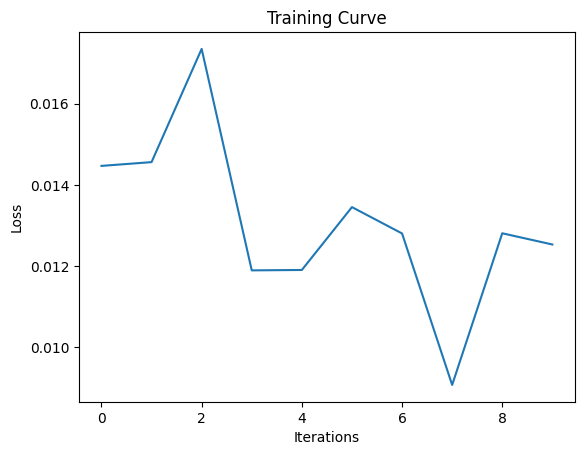

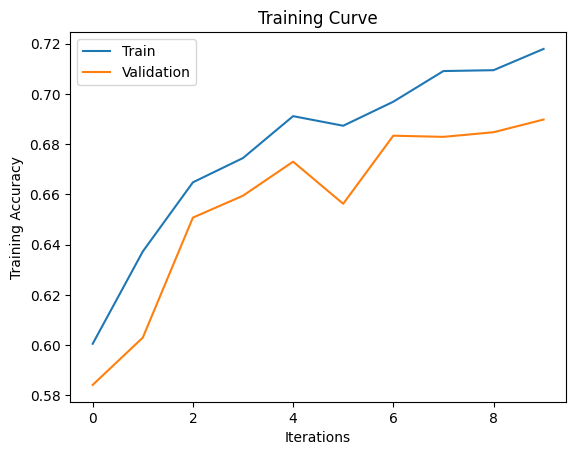

Final Training Accuracy: 0.7178925088820016
Final Validation Accuracy: 0.6897818599311136


In [ ]:
model = CNNbaseline()
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Training on GPU ...')
else:
  print('CUDA is not available. Training on CPU ...')

trainCNN(model, oversampled_train_dataset, val_dataset, batch_size=64, learn_rate = 0.0001, num_epochs=10)

### Without Oversampling

CUDA is available! Training on GPU ...
Epoch 0 train accuracy: 0.6058659006727644 | val accuracy: 0.5921928817451205 | Time elapsed: 114.17336177825928
Epoch 1 train accuracy: 0.6446821377277194 | val accuracy: 0.618828932261768 | Time elapsed: 112.58053731918335
Epoch 2 train accuracy: 0.6582508126086628 | val accuracy: 0.6298507462686567 | Time elapsed: 112.50744366645813
Epoch 3 train accuracy: 0.6804747146420742 | val accuracy: 0.651435132032147 | Time elapsed: 112.71176338195801
Epoch 4 train accuracy: 0.6876559074759997 | val accuracy: 0.6629161882893226 | Time elapsed: 112.52040362358093
Epoch 5 train accuracy: 0.6862196689092146 | val accuracy: 0.6587830080367394 | Time elapsed: 112.39167976379395
Epoch 6 train accuracy: 0.7021694761508807 | val accuracy: 0.6849598163030999 | Time elapsed: 110.96517324447632
Epoch 7 train accuracy: 0.7107491117998337 | val accuracy: 0.6861079219288174 | Time elapsed: 110.12426090240479
Epoch 8 train accuracy: 0.7182326706478191 | val accuracy: 

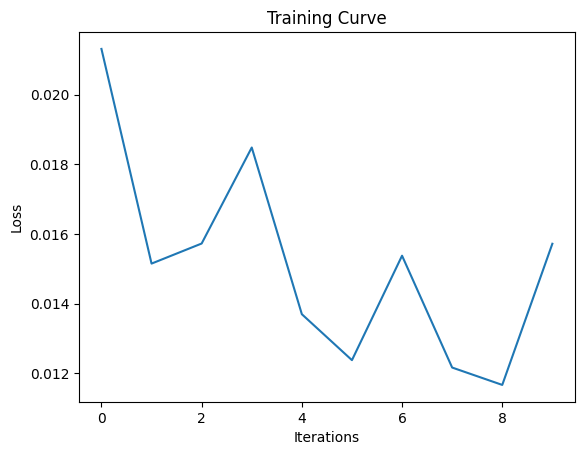

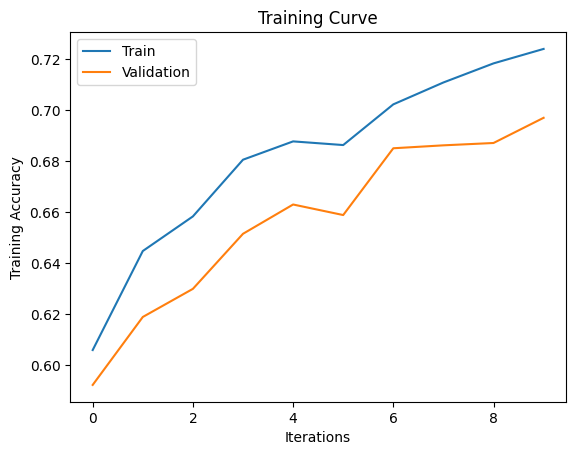

Final Training Accuracy: 0.7239020334114445
Final Validation Accuracy: 0.6969001148105626


In [ ]:
model = CNNbaseline(name = "OversampledCNN")
use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Training on GPU ...')
else:
  print('CUDA is not available. Training on CPU ...')

trainCNN(model, train_dataset, val_dataset, batch_size=64, learn_rate = 0.0001, num_epochs=10)

# EfficientNet Transfer Learning

## Train Loop

In [ ]:
train_size = sum([3792, 3834, 3851, 3681, 3781, 3745, 3774])
val_size = sum([419, 360, 744, 840, 830, 744, 418])

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

def trainTL(model, criterion, optimizer, scheduler, num_epochs=25, batch_size = 64):
    since = time.time()
    train_loader = torch.utils.data.DataLoader(oversampled_train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    iters, train_loss, val_loss, train_acc, val_acc = [], [], [], [], []

    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                dataloader = train_loader
                dataset_sizes = train_size
            else:
                model.eval()   # Set model to evaluate mode
                dataloader = val_loader
                dataset_sizes = val_size

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes
            epoch_acc = running_corrects.double() / dataset_sizes

            print(f'{phase} Loss: {epoch_loss} Acc: {epoch_acc}')

            if phase == "train":
              train_acc.append(epoch_acc.cpu())
              train_loss.append(epoch_loss)
              iters.append(n)
            
            else:
              val_acc.append(epoch_acc.cpu())
              val_loss.append(epoch_loss)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        n += 1
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # plotting
    plt.title("Loss Curve")
    plt.plot(iters, train_loss, label="Train")
    plt.plot(iters, val_loss, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


## Define Transfer Learning Model

In [ ]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_V2_L_Weights.DEFAULT # .DEFAULT = best available weights 
modelEN = torchvision.models.efficientnet_v2_l(weights=weights)

# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in modelEN.features.parameters():
    param.requires_grad = False

modelEN.classifier = nn.Sequential(nn.Linear(1280, 512),
                                   nn.ReLU(),
                                   nn.Linear(512, 256),
                                   nn.ReLU(),
                                   nn.Linear(256, 7))
                                   
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(modelEN, 
        input_size=(64, 3, 150, 150), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:04<00:00, 114MB/s]
/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 150, 150]    [64, 7]              --                   Partial
├─Sequential (features)                                      [64, 3, 150, 150]    [64, 1280, 5, 5]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 150, 150]    [64, 32, 75, 75]     --                   False
│    │    └─Conv2d (0)                                       [64, 3, 150, 150]    [64, 32, 75, 75]     (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 75, 75]     [64, 32, 75, 75]     (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 75, 75]     [64, 32, 75, 75]     --                   --
│    └─Sequential (1)                                        [64, 32, 75, 75]     [64, 

## Train EfficientNet TL Model 

Epoch 0/9
----------
train Loss: 1.669281940592129 Acc: 0.47282485448635575
val Loss: 1.1757333214329524 Acc: 0.6381171067738232

Epoch 1/9
----------
train Loss: 0.8903318305424313 Acc: 0.7026230251719707
val Loss: 0.7960818512978975 Acc: 0.7196326061997704

Epoch 2/9
----------
train Loss: 0.7177089195743838 Acc: 0.7460881396930985
val Loss: 0.7036136076076707 Acc: 0.7478760045924225

Epoch 3/9
----------
train Loss: 0.6653004504627035 Acc: 0.7641545090331847
val Loss: 0.6574861071139882 Acc: 0.765097588978186

Epoch 4/9
----------
train Loss: 0.654990860813734 Acc: 0.7661576838763323
val Loss: 0.6727269618984753 Acc: 0.7586681974741676

Epoch 5/9
----------
train Loss: 0.6279453937541836 Acc: 0.7801421120266083
val Loss: 0.6489322193591384 Acc: 0.7676234213547647

Epoch 6/9
----------
train Loss: 0.6213648145147819 Acc: 0.7812381888275759
val Loss: 0.6154077417951774 Acc: 0.7820895522388059

Epoch 7/9
----------
train Loss: 0.5976096358111102 Acc: 0.7892886839519239
val Loss: 0.6429

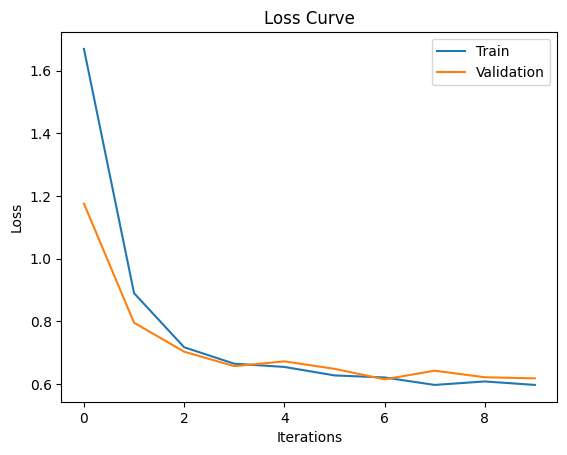

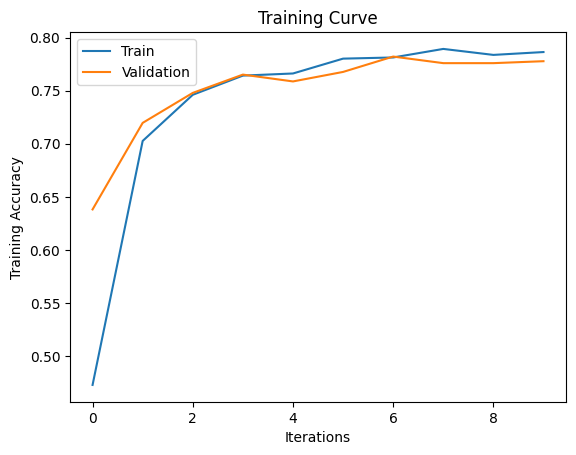

Final Training Accuracy: 0.7863406153148387
Final Validation Accuracy: 0.7777267508610792


In [ ]:
# Define loss and optimizer
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(modelEN.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

modelEN.cuda()

model_ft = trainTL(modelEN, criterion, optimizer, exp_lr_scheduler,
                       num_epochs=10)

torch.save(model_ft, "efficientnet")

# Test CNN/EfficientNet

## Test Accuracy

In [ ]:
def get_test_accuracy(model, test_loader):
    correct = 0
    total = 0
    for imgs, labels in test_loader:
        
        #############################################
        #To Enable GPU Usage
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################

        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]

    return correct / total

## Baseline CNN Accuracy

In [ ]:
model_CNN = CNNbaseline()
if torch.cuda.is_available():
    model_CNN.cuda()
    
state = torch.load("/content/gdrive/MyDrive/landscape-generation-and-classification Project/model_OversampledCNN_bs64_lr0 (1).0001_epoch9")
model_CNN.load_state_dict(state)
model_CNN.eval()

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_accuracy = get_test_accuracy(model_CNN, test_loader)
print(f"Test accuracy: {test_accuracy * 100}%")

Test accuracy: 69.6969696969697%


## EfficientNet TL Accuracy

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
modelEN = torch.load("/content/gdrive/MyDrive/landscape-generation-and-classification/efficientnet")
modelEN.eval()
test_accuracy = get_test_accuracy(modelEN, test_loader)
print(f"Test accuracy: {test_accuracy * 100}%")

Test accuracy: 76.81359044995408%


## Visualize Classification Models

## Display Images

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


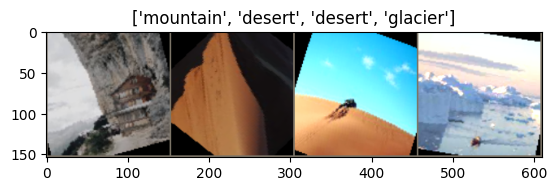

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

class_names = ['buildings', 'desert', 'forest', 'glacier', 'mountain', 'sea', 'street']
train_loader1 = torch.utils.data.DataLoader(oversampled_train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True)
# Get a batch of training data
inputs, classes = next(iter(train_loader1))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Test using Test Data

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10, shuffle=True, num_workers=4, pin_memory=True)
    y_pred = []
    y_true = []

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            y_pred += preds.tolist()
            y_true += labels.tolist()

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
        
        cm = confusion_matrix(y_true, y_pred)
        sns.set()
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()



### EfficientNet TL

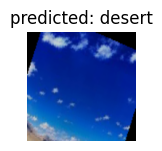

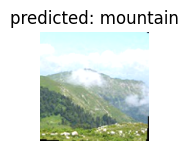

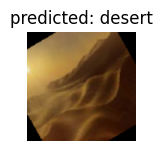

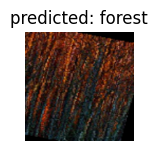

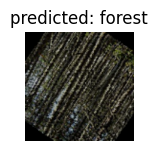

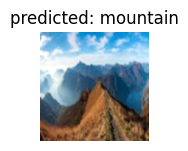

In [ ]:
visualize_model(modelEN)

### Baseline CNN

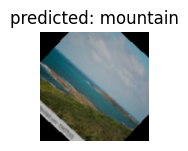

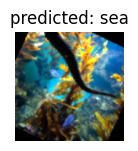

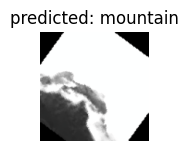

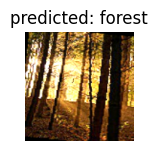

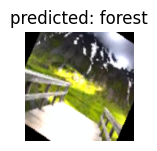

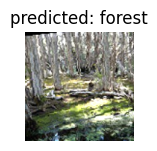

In [ ]:
visualize_model(model_CNN)

## Test with single image CNN

6


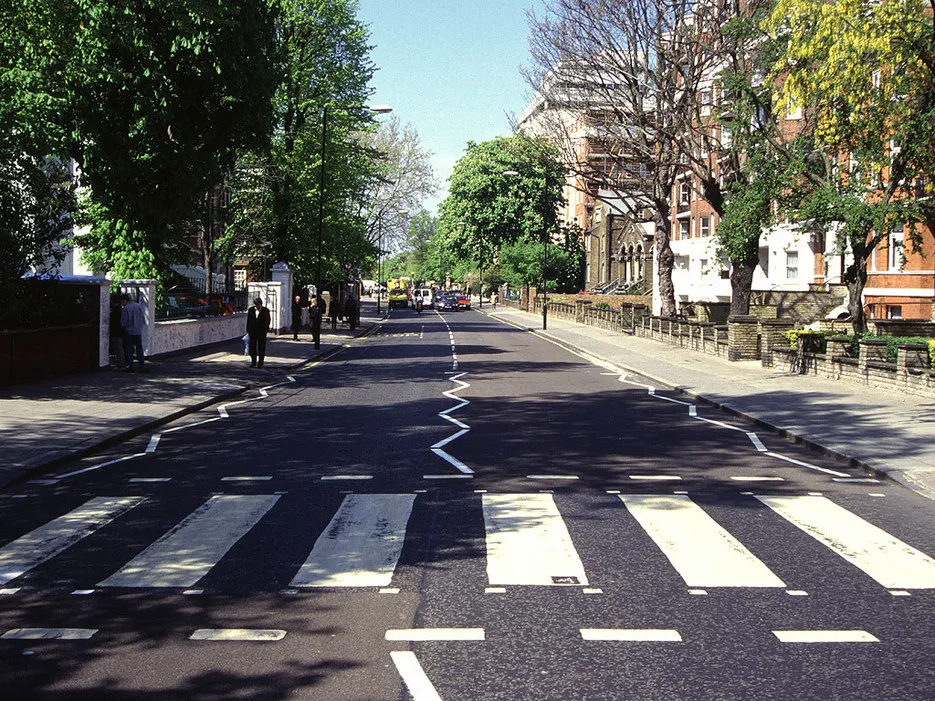

In [ ]:
from PIL import Image

# Load the image and convert it to a tensor
image = Image.open('/content/gdrive/MyDrive/landscape-generation-and-classification Project/abbey-road-london.webp')
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image_tensor = transform(image)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_CNN.to(device)

# Move the input tensor to the same device as the model's weights
image_tensor = image_tensor.to(device)

# Pass the image through the model and get the predicted class
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))
    predicted = torch.argmax(output.data, 1)

# Print the predicted class
print(predicted.item())
image.show()

## Test with Single Image EfficientNet

In [ ]:
from PIL import Image

# Load the image and convert it to a tensor
image = Image.open('/content/gdrive/MyDrive/landscape-generation-and-classification/abbey-road-london.webp')
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
image_tensor = transform(image)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelEN.to(device)

# Move the input tensor to the same device as the model's weights
image_tensor = image_tensor.to(device)

# Pass the image through the model and get the predicted class
with torch.no_grad():
    output = model(image_tensor.unsqueeze(0))
    predicted = torch.argmax(output.data, 1)

# Print the predicted class
print(predicted.item())
image.show()

# Convolutional Autoencoder

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride = 2, padding = 2, output_padding = 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
summary(model=model, 
        input_size=(64, 3, 150, 150), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Autoencoder (Autoencoder)                [64, 3, 150, 150]    [64, 3, 150, 150]    --                   True
├─Sequential (encoder)                   [64, 3, 150, 150]    [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                        [64, 3, 150, 150]    [64, 16, 75, 75]     448                  True
│    └─ReLU (1)                          [64, 16, 75, 75]     [64, 16, 75, 75]     --                   --
│    └─Conv2d (2)                        [64, 16, 75, 75]     [64, 32, 38, 38]     4,640                True
│    └─ReLU (3)                          [64, 32, 38, 38]     [64, 32, 38, 38]     --                   --
│    └─Conv2d (4)                        [64, 32, 38, 38]     [64, 64, 32, 32]     100,416              True
├─Sequential (decoder)                   [64, 64, 32, 32]     [64, 3, 150, 150]    --                   True
│    └─ConvTranspo

## Train Loop

In [ ]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5)
    train_loader = torch.utils.data.DataLoader(oversampled_train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=2, 
                                               pin_memory=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              img = img.cuda()
            #############################################  

            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

model = Autoencoder()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  model.cuda()
  print('CUDA is available! Training on GPU ...')
else:
  print('CUDA is not available. Training on CPU ...')

max_epochs = 10
outputsAE = train(model, num_epochs=max_epochs)

CUDA is available! Training on GPU ...
Epoch:1, Loss:1.0259
Epoch:2, Loss:1.0797
Epoch:3, Loss:0.9844
Epoch:4, Loss:1.1668
Epoch:5, Loss:1.0608
Epoch:6, Loss:1.0444
Epoch:7, Loss:1.1959
Epoch:8, Loss:0.9588
Epoch:9, Loss:1.0862
Epoch:10, Loss:0.8922


## Visualize Generated Images 

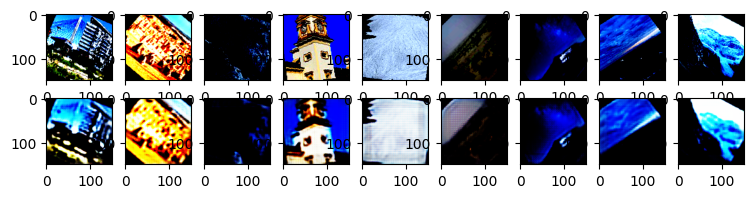

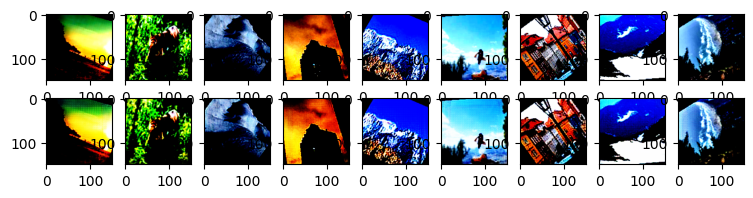

In [ ]:
for k in range(0, 10, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputsAE[k][1].cpu().detach().numpy()
    recon = outputsAE[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item1 = item.transpose(1, 2, 0)
        plt.imshow(item1)
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        item2 = item.transpose(1, 2, 0)
        plt.imshow(item2)

# Variational Autoencoder

In [ ]:
# dimensions of latent space
zdim = 64

# Variational Autoencoder
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(3, 16, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride = 2, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        #self.fc1 = nn.Linear(64 * 32 * 32, 350)
        self.relu = nn.ReLU()
        self.fc2m = nn.Linear(64 * 32 * 32, zdim)  # mu layer
        self.fc2s = nn.Linear(64 * 32 * 32, zdim)  # sd layer

        # decoder
        self.fc3 = nn.Linear(zdim, 64 * 32 * 32)
        #self.fc4 = nn.Linear(350, 64 * 32 * 32)
        #self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride = 2, padding = 2, output_padding = 1),
            nn.Tanh()
        )

    def encode(self, x):
        x = self.encoder(x)
        h1 = x.view(-1, 64 * 32 * 32)
        return self.fc2m(h1), self.fc2s(h1)

    # reparameterize
    def reparameterize(self, mu, logvar):
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = std.data.new(std.size()).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

    def decode(self, z):
        h3 = self.relu(self.fc3(z))
        x = h3.view(-1, 64, 32, 32)
        x = self.decoder(x)
        return x

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


model = VAE()
summary(model= model, 
        input_size=(64, 3, 150, 150), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VAE (VAE)                                [64, 3, 150, 150]    [64, 3, 150, 150]    --                   True
├─Sequential (encoder)                   [64, 3, 150, 150]    [64, 64, 32, 32]     --                   True
│    └─Conv2d (0)                        [64, 3, 150, 150]    [64, 16, 75, 75]     448                  True
│    └─ReLU (1)                          [64, 16, 75, 75]     [64, 16, 75, 75]     --                   --
│    └─Conv2d (2)                        [64, 16, 75, 75]     [64, 32, 38, 38]     4,640                True
│    └─ReLU (3)                          [64, 32, 38, 38]     [64, 32, 38, 38]     --                   --
│    └─Conv2d (4)                        [64, 32, 38, 38]     [64, 64, 32, 32]     100,416              True
├─Linear (fc2m)                          [64, 65536]          [64, 64]             4,194,368            True
├─Linear (fc2s)   

## Train Loop

In [ ]:
# loss function for VAE are unique and use Kullback-Leibler
# divergence measure to force distribution to match unit Gaussian
def loss_function(recon_x, x, mu, logvar, batch_size):
    mse = F.mse_loss(recon_x, x, reduction='sum')
    kld = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    kld /= batch_size * 150 * 150 * 3
    return mse + kld


In [ ]:
def train(model, num_epochs = 1, batch_size = 64, learning_rate = 0.0001):
    model.train() #train mode so that we do reparameterization
    
    train_loader = torch.utils.data.DataLoader(oversampled_train_dataset, 
                                               batch_size=batch_size, 
                                               shuffle=True, 
                                               num_workers=2, 
                                               pin_memory=True)
    
    optimizer = optim.Adam(model.parameters(), learning_rate)
    
    outputs = []
    for epoch in range(num_epochs):
      for data in train_loader:  # load batch
          img, _ = data

          #############################################
          #To Enable GPU Usag
          img = img.cuda()
          #############################################  
          recon, mu, logvar = model(img)
          
          loss = loss_function(recon, img, mu, logvar, batch_size) # calculate loss
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
      
      print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
      outputs.append((epoch, img, recon),)
    
    return model, outputs
    

batch_size = 64

modelVAE = VAE()

use_cuda = True
if use_cuda and torch.cuda.is_available():
  modelVAE.cuda()
  print('CUDA is available! Training on GPU ...')
else:
  print('CUDA is not available. Training on CPU ...')

modelVAE, outputs1 = train(modelVAE, num_epochs = 20, batch_size = batch_size)

CUDA is available! Training on GPU ...
Epoch:1, Loss:1410889.7500
Epoch:2, Loss:1128050.5000
Epoch:3, Loss:993670.8125
Epoch:4, Loss:1173202.2500
Epoch:5, Loss:1097230.2500
Epoch:6, Loss:1009665.0000
Epoch:7, Loss:1102078.0000
Epoch:8, Loss:811252.3750
Epoch:9, Loss:803960.3750
Epoch:10, Loss:940348.0000
Epoch:11, Loss:875321.6250
Epoch:12, Loss:1038789.8750
Epoch:13, Loss:850001.4375
Epoch:14, Loss:907622.7500
Epoch:15, Loss:846431.3125
Epoch:16, Loss:902878.1875
Epoch:17, Loss:742617.6875
Epoch:18, Loss:944560.6875
Epoch:19, Loss:856543.7500
Epoch:20, Loss:976284.0000


## Visualize Generated Images 

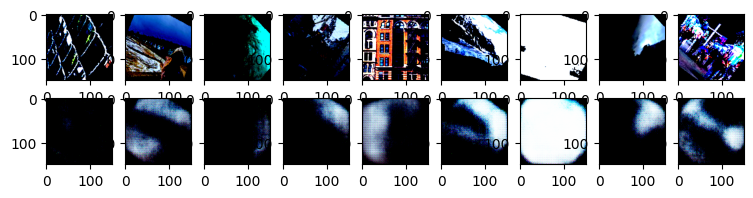

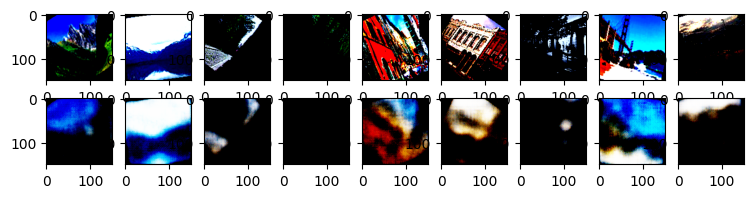

In [ ]:
for k in range(0, 10, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs1[k][1].cpu().detach().numpy()
    recon = outputs1[k][2].cpu().detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        item1 = item.transpose(1, 2, 0)
        plt.imshow(item1)
        
    for i, item in enumerate(recon):
        if i >= 9: break
        item = item.reshape(3, 150, 150)
        plt.subplot(2, 9, 9+i+1)
        item2 = item.transpose(1, 2, 0)
        plt.imshow(item2)

In [ ]:
torch.save(modelVAE, "VAE")

# Testing EfficientNet from Reconstructed VAE images

## Load VAE and EfficientNet TL Models

In [ ]:
modelVAE = torch.load("/content/gdrive/MyDrive/landscape-generation-and-classification/VAE")
modelVAE.eval()

VAE(
  (fc1): Linear(in_features=67500, out_features=350, bias=True)
  (relu): ReLU()
  (fc2m): Linear(in_features=350, out_features=25, bias=True)
  (fc2s): Linear(in_features=350, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=350, bias=True)
  (fc4): Linear(in_features=350, out_features=67500, bias=True)
  (sigmoid): Sigmoid()
)

In [ ]:
modelEN = torch.load("./content/gdrive/MyDrive/landscape-generation-and-classificationefficientnet")
modelEN.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): FusedMBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  

4


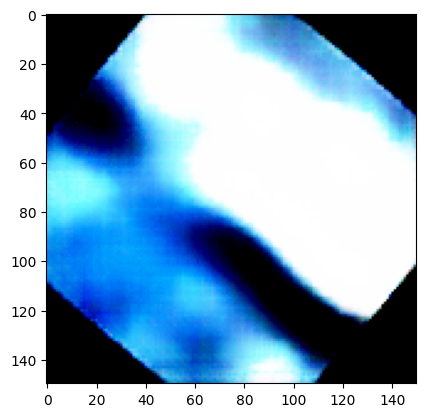

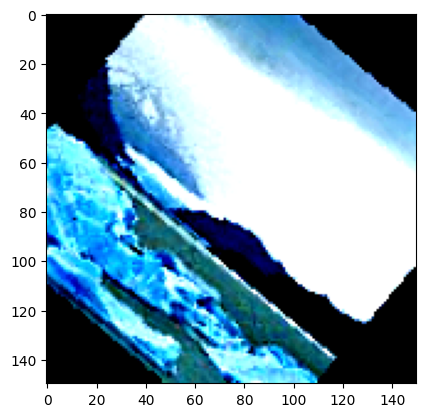

In [ ]:
recon = outputs1[9][2].cpu().detach().numpy()
img = recon[2]

imgs = outputs1[9][1].cpu().detach().numpy()
input = imgs[2]

class_names = ['buildings', 'desert', 'forest', 'glacier', 'mountain', 'sea', 'street']
  
# Convert the NumPy array to a PyTorch tensor
image_tensor = torch.from_numpy(img)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
modelEN.to(device)

# Move the input tensor to the same device as the model's weights
image_tensor = image_tensor.to(device)

# Pass the image through the model and get the predicted class
with torch.no_grad():
    output = modelEN(image_tensor.unsqueeze(0))
    predicted = torch.argmax(output.data, 1)

# Print the predicted class
print(predicted.item())
plt.imshow(img.transpose(1, 2, 0))
plt.show()
plt.imshow(input.transpose(1, 2, 0))
plt.show()